# Development of classification models for mode choices



Assignment task: Find the best classification model for the travel mode choices prediction (assignment submission) 

Your task is to analyse the provided dataset, which contains information about individuals' choices of travel mode.

Identify which classification model works the best and whether there is a considerable difference in the results.
Identify which model, together with its corresponding hyperparameters, gives the best performance for mode choice predictions.
Provide a reflection on the underlying reasons why certain classification models may achieve better prediction accuracy compared to others when applied to this dataset.
What would you suggest doing to improve the prediction accuracy of the developed classification models (any opinion about the dataset?)

### Data Overview

##### Importing libraries

In [8]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import accuracy_score, precision_score, mean_squared_error, r2_score, roc_curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [2]:
data = pd.read_csv('modeChoiceData.csv')

In [3]:
column_names = data.columns
print(column_names)

Index(['ID', 'time_car', 'cost_car', 'time_bus', 'cost_bus', 'access_bus',
       'time_air', 'cost_air', 'access_air', 'service_air', 'time_rail',
       'cost_rail', 'access_rail', 'service_rail', 'choice'],
      dtype='object')


In [4]:
data.head(5)

,ID,time_car,cost_car,time_bus,cost_bus,access_bus,time_air,cost_air,access_air,service_air,time_rail,cost_rail,access_rail,service_rail,choice
0,1,275,50,330,35,20,80,65,55,food,120,45,5,no-frills,air
1,2,275,45,330,15,5,70,110,40,wifi,170,55,25,food,rail
2,3,275,45,390,15,25,70,80,55,no-frills,155,35,5,no-frills,rail
3,4,300,45,300,15,10,60,110,40,wifi,155,65,20,no-frills,rail
4,5,390,35,390,35,10,60,95,45,wifi,155,65,15,food,rail


The goal is to predict the 'choice' attribute.

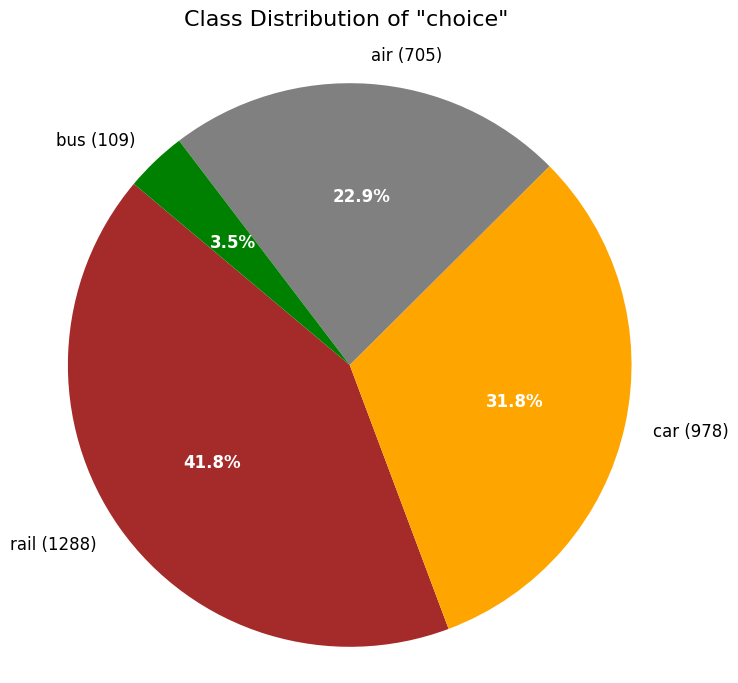

In [5]:
class_counts = data['choice'].value_counts()
plt.figure(figsize=(8, 8))
colors = ['brown', 'orange', 'grey', 'green']  # Customize colors as needed
patches, texts, autotexts = plt.pie(
    class_counts, 
    labels=class_counts.index, 
    autopct='%1.1f%%', 
    colors=colors, 
    startangle=140,
    textprops={'fontsize': 12}  # Set font size for count labels
)
plt.title('Class Distribution of "choice" \n',fontsize=16)
plt.axis('equal')

for text, autotext in zip(texts, autotexts):
    autotext.set_color('white')  # Set count label color to white for better visibility
    autotext.set_fontweight('bold')  # Set font weight to bold
    text.set_fontsize(12)  # Set font size for choice labels
    # text.set_fontweight('bold')  # Set font weight to bold
    text.set_text(text.get_text() + f' ({class_counts[text.get_text()]})')

plt.show()

There is an imbalance of class distribution.

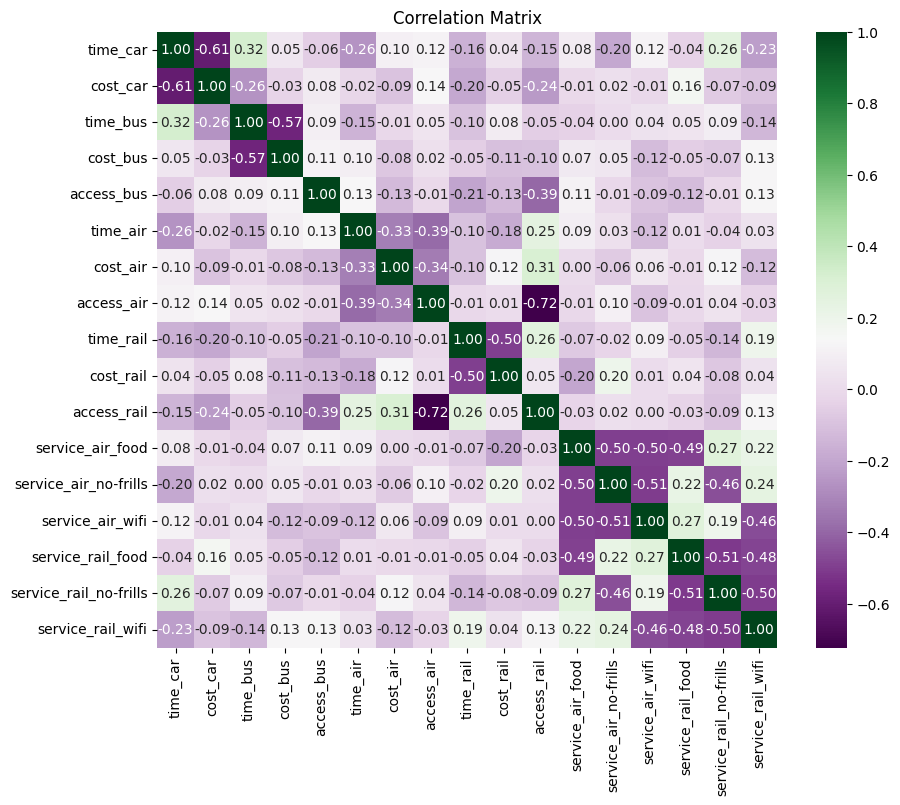

In [6]:
data_encoded = pd.get_dummies(data, columns=['service_air', 'service_rail'])
correlation_data = data_encoded.drop(['choice','ID'], axis=1)
correlation_matrix = correlation_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='PRGn', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


We can observe that an cost for a mode of transport has a strong negative correlation with it's corresponding access. There is also weak correlation between the cost of one mode and the access of some other mode. 

In [7]:
missing_data = data.isnull().sum()
print(missing_data)

ID              0
time_car        0
cost_car        0
time_bus        0
cost_bus        0
access_bus      0
time_air        0
cost_air        0
access_air      0
service_air     0
time_rail       0
cost_rail       0
access_rail     0
service_rail    0
choice          0
dtype: int64



There are no null values.

In [9]:
# Timer function
from datetime import datetime
# Timer function
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

#### Encoding

In [36]:
df = pd.get_dummies(data, columns=['service_air', 'service_rail'])


In [37]:
x = df.drop(['choice','ID',], axis=1)
y = df['choice']

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25,random_state=0)


##### Logistic Regression

In [40]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2'],  # Regularization type
    'solver': ['newton-cg','lbfgs','newton-cholesky','liblinear','sag']  # Algorithm to use for optimization
}
lr = LogisticRegression(max_iter=2000, random_state=0)
folds = 5
param_comb = 25 #choosing 100 combinations randomly out of 405

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid_search = GridSearchCV(estimator=lr, param_grid=lr_params, scoring='accuracy', n_jobs=4, cv=skf.split(x_train,y_train), verbose=3 )

start_time = timer(None) # timing starts from this point for "start_time" variable
grid_search.fit(x_train,y_train)
timer(start_time) # timing ends here for "start_time" variable


best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Time taken: 0 hours 0 minutes and 2.97 seconds.
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [41]:
best_lr = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'], max_iter=2000, random_state=0)

The accuracy of the Logistic Regression model is: 0.5701298701298702
The precision of the Logistic Regression model is: [0.54601227 0.         0.47058824 0.66268657]
The recall of the Logistic Regression model is: [0.52352941 0.         0.53333333 0.6686747 ]


c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


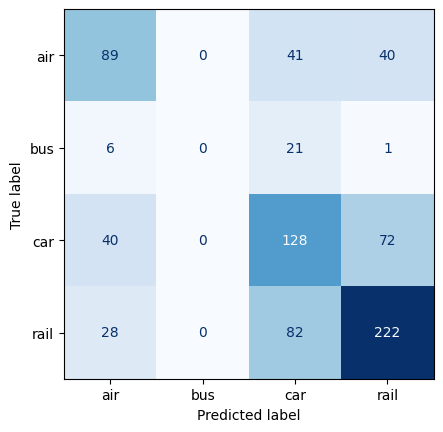

In [42]:
best_lr.fit(x_train, y_train)
y_pred = best_lr.predict(x_test)
cmd.from_estimator(best_lr, x_test, y_test,cmap='Blues',colorbar=False)

# # Calculate the accuracy of the model by comparing predicted labels to true labels
print('The accuracy of the Logistic Regression model is: '+str(accuracy_score(y_test,best_lr.predict(x_test))))
print('The precision of the Logistic Regression model is: '+str(precision_score(y_test,best_lr.predict(x_test),average=None)))
print('The recall of the Logistic Regression model is: '+str(recall_score(y_test,best_lr.predict(x_test),average=None)))
